# Data Ops Challenge Main Analysis File
In this file, I'll be using a Jupyter notebook to produce the core visualizations that will supplement the presentation and be used for answering the provided guiding questions.

## Loading, Adjusting, and Merging the Data

In [1]:
#imports
import sqlite3
import pandas as pd
import plotly.graph_objects as plt
import matplotlib.pyplot as plot
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np

In [2]:
#first, i'm going to initially connect to the database
conn = sqlite3.connect("challenge.db")

#now i'll load in each table as a dataframe
cities_df = pd.read_sql("SELECT * FROM five_hundred_cities;", conn)
access_df = pd.read_sql("SELECT * FROM access;", conn)
variablelist_df = pd.read_sql("SELECT * FROM variable_list", conn)

print(f"number of rows from the 500 cities dataset: {len(cities_df):,}")
print(f"number of rows from the fda food atlas dataset: {len(access_df):,}")

number of rows from the 500 cities dataset: 27,210
number of rows from the fda food atlas dataset: 3,143


In [3]:
#now, when reading through the tables, i saw that the FIPS value for the access table was NOT the standard 5 digits for some
#of the codes. after looking up the FIPS codes, i found out that any FIPS code that originally had a "0" at the beginning
#was now missing a 0 at the beginning. if it had a non-zero value at the beginning, it still had that value. so i'll be
#adding in a zero at the beginning of each FIPS code that was supposed to have a 0 in the access table
#this was actually the case in the 500 cities dataset as well, with the PlaceFIPS and TractFIPS codes so i fixed that too.
#i've included a print before and after to show that this was the case.

print(cities_df["TractFIPS"].head())
cities_df["TractFIPS"] = cities_df["TractFIPS"].astype(str).str.zfill(11).str[:5]
cities_df["CountyFIPS"] = cities_df["TractFIPS"]
print(cities_df["CountyFIPS"].head())

print(access_df["FIPS"].head(10))
access_df["FIPS"] = access_df["FIPS"].astype(str).str.zfill(5)
print(access_df["FIPS"].head(10))

0    1073000100
1    1073000300
2    1073000400
3    1073000500
4    1073000700
Name: TractFIPS, dtype: int64
0    01073
1    01073
2    01073
3    01073
4    01073
Name: CountyFIPS, dtype: object
0    1001
1    1003
2    1005
3    1007
4    1009
5    1011
6    1013
7    1015
8    1017
9    1019
Name: FIPS, dtype: int64
0    01001
1    01003
2    01005
3    01007
4    01009
5    01011
6    01013
7    01015
8    01017
9    01019
Name: FIPS, dtype: object


In [4]:
#we will extract lat/lon from geolocation "(lat, lon)" strings for visualization purposes later (specifically visualization 1)
cities_df[["lat","lon"]] = cities_df["Geolocation"].str.strip("()").str.split(",", expand=True)
cities_df["lat"] = cities_df["lat"].astype(float)
cities_df["lon"] = cities_df["lon"].astype(float)

In [5]:
#now we can aggregate the 500 cities data to a county-level

#key columns we use in analysis for visualizations
disease_cols = ["COPD_CrudePrev", "CASTHMA_CrudePrev", "DIABETES_CrudePrev", 
                "ARTHRITIS_CrudePrev", "BPHIGH_CrudePrev"]
engagement_cols = ["COREM_CrudePrev", "COREW_CrudePrev"]
key_cols = disease_cols + engagement_cols + ["Population2010"]

#drop rows with missing vals in key cols
cities_clean = cities_df.dropna(subset=key_cols + ["CountyFIPS", "lat", "lon"]).copy()
print(f"rows dropped due to missing data: {len(cities_df) - len(cities_clean)}")
print(f"remaining rows: {len(cities_clean):,}")

#aggregate to county level using population-weighted means for prevalence
county_health = cities_clean.groupby("CountyFIPS").apply(
    lambda x: pd.Series({
        'State': x['StateAbbr'].iloc[0],
        'County': x['TractFIPS'].iloc[0],  
        'total_pop': x['Population2010'].sum(),
        'COPD_CrudePrev': np.average(x['COPD_CrudePrev'], weights=x['Population2010']),
        'CASTHMA_CrudePrev': np.average(x['CASTHMA_CrudePrev'], weights=x['Population2010']),
        'DIABETES_CrudePrev': np.average(x['DIABETES_CrudePrev'], weights=x['Population2010']),
        'ARTHRITIS_CrudePrev': np.average(x['ARTHRITIS_CrudePrev'], weights=x['Population2010']),
        'BPHIGH_CrudePrev': np.average(x['BPHIGH_CrudePrev'], weights=x['Population2010']),
        'COREM_CrudePrev': np.average(x['COREM_CrudePrev'], weights=x['Population2010']),
        'COREW_CrudePrev': np.average(x['COREW_CrudePrev'], weights=x['Population2010']),
        'lat': x['lat'].mean(),
        'lon': x['lon'].mean()
    }), include_groups=False
).reset_index()

rows dropped due to missing data: 152
remaining rows: 27,058


In [6]:
#now we can merge the FDA food access data with the 500 cities data
print(f"counties in FDA data before cleaning: {len(access_df):,}")
#clean fda data with replacing missing codes and dropping na values
access_clean = (
    access_df
    .replace([-9999, -8888, -1], np.nan)
    .dropna(subset=["FIPS", "County", "State", "PCT_LACCESS_POP15"]) 
    .copy()
)
print(f"counties in FDA data after cleaning: {len(access_clean):,}")

#merge the two datasets on county FIPS
merged = county_health.merge(
    access_clean,
    left_on="CountyFIPS",
    right_on="FIPS",
    how="inner"
)
print(f"counties after merging: {len(merged):,}")

counties in FDA data before cleaning: 3,143
counties in FDA data after cleaning: 3,124
counties after merging: 324


## Visualization 1 (the where)
This visualization aims to help supplement the guiding question **"where should we deploy a food access program?"**

We can find this out by first considering that the only table we have available for analysis from the FDA Food Access dataset is the "ACCESS" sub-table, which contains information about access and proximity to grocery stores with the following subcategories within that category:
- overall (population with low-access)
- household resources (low income & low access, households with no car & low access, SNAP households & low access)
- demographics (children, seniors, hispanic ethnicity, asian, american indian or alaska native, asian, hawaiian or pacific islander, multiracial with low access)

We should also consider that for the 500 cities dataset, though some of the columns regarding different health conditions and their prevalences only consider elderly populations (>= 65 years old or 50-74 years old) or only adult men or only adult women, generally it doesn't account for factors such as household resources or demographics but rather just for a general age range (18-64), it looks at "what is the crude prevalence of this health condition?"

Since we want to consider data from both datasets when we are considering where to deploy a food access program, we'll only consider the overall access to grocery stores (general population with low-access) from the FDA Food Access dataset so as to match the generality of the 500 cities dataset.

Though we have past data that we can use and a percent change we can consider with access to food in specific areas (change from 2010-2015), I will only be using the percentage of population impacted by low access to food in specific areas from the most recent data (2015) so that we can target where need is highest now. For an example on why we want to target this to answer the question of where we should deploy a food access program now, we can consider that if we have a town with a large change of overall low access to grocery stores of 3% to 6% from 2010 to 2015 and another town with no change of overall low access to grocery stores of 25% to 25% from 2010 to 2015, we would want to target the latter town for food access programs since, although they have didn't change, they are experiencing more food access challenges with more of their population now.

In a 2024 study by Gregory and Jones on health challenges related to household food security (https://www.ers.FDA.gov/data-products/charts-of-note/chart-detail?chartId=108211), it was found that 5 chronic diseases increased their prevalence as household food security worsened. These diseases were **hypertension, arthritis, diabetes, asthma, and COPD**. The age range included was ages 19-64 working adults, with compared household food security ranging from high, marginal, low, and very low. I'll be using these 5 diseases as the target ones to look for in the 500 cities dataset related to low food access in the FDA food atlas dataset when trying to find locations to deploy a food access program.

In [7]:
#what are the columns that I want to analyze for this? (note: hypertension = long-term high blood pressure)
    #county, city, state for the actual location (County, PlaceName, State)
    #PCT_LACCESS_POP15 from the FDA food atlas dataset -> indicates population, low access to store (%), 2015
    #COPD_CrudePrev from the 500 cities dataset -> indicates the model-based estimate for crude prevalence of chronic obstructive pulmonary disease among adults aged >=18 years
    #CASTHMA_CrudePrev from the 500 cities dataset -> indicates the model-based estimate for crude prevalence of current asthma among adults aged >=18 years
    #DIABETES_CrudePrev from the 500 cities dataset -> indicates the model-based estimate for crude prevalence of diagnosed diabetes among adults aged >=18 years
    #ARTHRITIS_CrudePrev from the 500 cities dataset -> indicates the model-based estimate for crude prevalence of arthritis among adults aged >=18 years
    #BPHIGH_CrudePrev from the 500 cities dataset -> indicates the model-based estimate for crude prevalence of high blood pressure among adults aged >=18 years

#first, what we'll do is calculate a "priority score" for each county that we have available in our merged dataset.
#the higher the score -> the more priority we should designate to that county to designate resources.
#why does this work? -> the additive model with equal weights (0.5 each) identifies counties 
#that score high on BOTH disease burden AND food access challenges

#creating a copy of the merged df for adding in the calculatuions of disease burden norm and food access norm and priority score for each location
vis1_data = merged.copy() 
#we calculate the disease burden and food access burden normalized on a 0-1 scale and then equally add them in 
#to the priority score (become a range of 0-100)
for col in disease_cols:
    vis1_data[f"{col}_norm"] = (vis1_data[col] - vis1_data[col].min()) / (vis1_data[col].max() - vis1_data[col].min())
vis1_data["disease_burden_norm"] = vis1_data[[f"{col}_norm" for col in disease_cols]].mean(axis=1)
vis1_data["food_access_norm"] = (vis1_data["PCT_LACCESS_POP15"] - vis1_data["PCT_LACCESS_POP15"].min()) / \
                                 (vis1_data["PCT_LACCESS_POP15"].max() - vis1_data["PCT_LACCESS_POP15"].min())
vis1_data["priority_score"] = (0.5 * vis1_data["disease_burden_norm"] + 0.5 * vis1_data["food_access_norm"]) * 100


#getting the relevant data for county display
county_data = vis1_data[["FIPS", "County_y", "State_y", "priority_score", "lat", "lon"]].copy()
county_data = county_data.rename(columns={"County_y": "County", "State_y": "State"}) 
state_data = county_data.groupby("State").agg(
    priority_score=("priority_score", "mean") #average priority score across all counties in that state
).reset_index() #make it into a normal df

#we also normalize the data to be on a 0-100 scale for the priority score on a state level so the visualization is easier to understand
min_val = state_data["priority_score"].min()
max_val = state_data["priority_score"].max()
state_data["priority_score_norm"] = ((state_data["priority_score"] - min_val) / (max_val - min_val) * 100)

#we get the top 10 highest priority score counties overall (not per state) to display on the map as the areas we should focus on
top10 = county_data.nlargest(10, "priority_score").copy()
top10 = top10.sort_values("priority_score", ascending=False).reset_index(drop=True)

#adding labels to the top 10 counties: rank, county, state and priority score
top10["RankLabel"] = (
    (top10.index+1).astype(str) + ". " +
    top10["County"] + ", " +
    top10["State"] +
    " (" + top10["priority_score"].round(1).astype(str) + ")"
)

In [8]:
#here we'll actually generate the figure!
fig = plt.Figure()
#the background will be a state-level heatmap chloropleth
fig.add_trace(plt.Choropleth(
    locations=state_data["State"], #which geographic places are being colored
    z=state_data["priority_score_norm"], #numeric values used to determine color for each state (normalized priority score)
    locationmode="USA-states", #how to interpret locations field
    colorscale="RdBu_r",   #color scheme to shade the states
    colorbar_title="Priority Score", #color bar title
    colorbar=dict(
        len=0.6,           #scales down the colorbar length (default is 1)
        thickness=15,      
        x=0.92,             
        y=0.5               
    ),
    showscale=True
))

#this overlays the top 10 counties we found before with markers and labels
for i, row in top10.iterrows():
    rank = i + 1
    fig.add_trace(plt.Scattergeo(
        lon=[row["lon"]],
        lat=[row["lat"]],
        mode="markers+text",
        name=f"{rank}. {row['County']}, {row['State']} ({row['priority_score']:.1f})",  
        text=f"#{rank}",                                 
        textposition="top center",
        marker=dict(
            size=10,
            color="black",
            symbol="circle",
            line=dict(width=1, color="white")
        ),
        showlegend=True,
        legendgroup=f"group{rank}",
        textfont=dict(size=12, color="black"),
        marker_symbol=None,
        hoverinfo="text"
    ))
fig.update_geos(scope="usa") #tells plotly to show the usa
fig.update_layout(
    title=dict(
        text="Food Access Program Deployment Areas<br> Top 10 High-Priority Score Counties Highlighted",
        y=0.8,
        x=0.5,
        xanchor="center",
        yanchor="top",
        font=dict(size=18)
    ),
    height=750,
    showlegend=True,
    legend=dict(
        title="Top 10 High-Priority Counties<br>(with priority scores)",
        x=-0.18,
        y=0.5,
        bgcolor="rgba(255,255,255,0.6)",
        bordercolor="gray",
        borderwidth=0.5,
        font=dict(size=11)
    )
)
fig.show() #show the figure


In [9]:
#getting information from the corgis csv file, making sure to only include the columns we need
#and clean the names
demographic_data = pd.read_csv('county_demographics.csv')
demographic_data = demographic_data.rename(columns={
    "County": "County",
    "State": "State",
    "Age.Percent 65 and Older": "Percent65plus"
})
#removing any extra words that might come after the county name in the csv file
def clean_county_name(name):
    return (name.replace(" County", "").replace(" Parish", "")
            .replace(" City", "").replace(" Borough", "")
            .strip().title())

demographic_data["County"] = demographic_data["County"].apply(clean_county_name)
demographic_data["State"] = demographic_data["State"].str.strip().str.upper()

#making sure that the percent 65 plus has no -1 values (missing values)
before_rows = len(demographic_data)
demographic_data = demographic_data[demographic_data["Percent65plus"] != -1].dropna(subset=["Percent65plus"])
after_rows = len(demographic_data)

print(f"{before_rows - after_rows} rows with missing -1 or NaN Percent65plus values")
print(f"remaining rows: {after_rows:,}")

0 rows with missing -1 or NaN Percent65plus values
remaining rows: 3,139


In [10]:
#for the subgroup part we have the following in the FDA food atlas for subgroups/demographics:
#household resources (low income & low access, households with no car & low access, SNAP households & low access)
#demographics (children, seniors, hispanic ethnicity, asian, american indian or alaska native, asian, hawaiian or pacific islander, multiracial with low access)
#we do have some missing information for 2010 values, so we will have to use the 2015 values for these demographics.

#getting top 10 counties data
vis2_county = merged[merged["FIPS"].isin(top10["FIPS"])].copy()
#cleaning formatting for merging
vis2_county["County_Clean"] = vis2_county["County_y"].str.strip().str.title()
vis2_county["State_Clean"] = vis2_county["State_y"].str.strip().str.upper()
#merging with CORGIS
vis2_county = vis2_county.merge(
    demographic_data[["County", "State", "Percent65plus"]],
    left_on=["County_Clean", "State_Clean"],
    right_on=["County", "State"],
    how="left"
)

#calculate actual number of 65+ population
vis2_county["population_65plus"] = vis2_county["total_pop"] * vis2_county["Percent65plus"] / 100

#we get only the top 10 counties (same as the ones plotted in visualization 1)
vis2_county = vis2_county[vis2_county["FIPS"].isin(top10["FIPS"])].copy()

#get the engaged population with using both COREM and COREW as representative of older adults who are actively using healthcare services
vis2_county["engagement_rate"] = (vis2_county["COREM_CrudePrev"] * 0.5) + (0.5 * vis2_county["COREW_CrudePrev"])
vis2_county["engaged"] = vis2_county["population_65plus"] * vis2_county["engagement_rate"] / 100

#adding rank info to the vis2_county dataframe so we can order the barplot
rank_map = dict(zip(top10["FIPS"], range(1, len(top10)+1)))
vis2_county["Rank"] = vis2_county["FIPS"].map(rank_map)
vis2_county = vis2_county.sort_values("Rank")
county_labels = vis2_county["Rank"].astype(str) + ". " + vis2_county["County"] + ", " + vis2_county["State"]

#calculating subgroup affected numbers -> first we get all the column names
subgroup_cols = [
    "LACCESS_LOWI15", "LACCESS_HHNV15", "LACCESS_SNAP15",
    "LACCESS_CHILD15", "LACCESS_SENIORS15", "LACCESS_WHITE15",
    "LACCESS_BLACK15", "LACCESS_HISP15", "LACCESS_NHASIAN15",
    "LACCESS_NHNA15", "LACCESS_NHPI15", "LACCESS_MULTIR15"
]
subgroup_totals = vis2_county[subgroup_cols].sum()
#separating subgroups into household and demographic subgroups for visualizations
household_dict = {
    "Low Income": subgroup_totals["LACCESS_LOWI15"],
    "Households w/ No Car": subgroup_totals["LACCESS_HHNV15"],
    "SNAP Households": subgroup_totals["LACCESS_SNAP15"]
}
household_groups = pd.DataFrame(list(household_dict.items()), columns=["Subgroup", "Count"])
household_groups["Percent"] = household_groups["Count"] / household_groups["Count"].sum() * 100
demographic_dict = {
    "Children": subgroup_totals["LACCESS_CHILD15"],
    "Seniors": subgroup_totals["LACCESS_SENIORS15"],
    "White": subgroup_totals["LACCESS_WHITE15"],
    "Black": subgroup_totals["LACCESS_BLACK15"],
    "Hispanic": subgroup_totals["LACCESS_HISP15"],
    "Asian": subgroup_totals["LACCESS_NHASIAN15"],
    "American Indian/Alaska Native": subgroup_totals["LACCESS_NHNA15"],
    "Hawaiian/Pacific Islander": subgroup_totals["LACCESS_NHPI15"],
    "Multiracial": subgroup_totals["LACCESS_MULTIR15"]
}
demographic_groups = pd.DataFrame(list(demographic_dict.items()), columns=["Subgroup", "Count"])
demographic_groups = demographic_groups.sort_values("Count", ascending=False)

In [11]:
#visualization 1 -> bar chart for total vs engaged population (65+ y/o)
fig1 = plt.Figure()
fig1.add_trace(
    plt.Bar(
        x=county_labels,
        y=vis2_county["population_65plus"],
        marker_color="#0277C8",
        name="Total 65+ Population"
    )
)
fig1.add_trace(
    plt.Bar(
        x=county_labels,
        y=vis2_county["engaged"],
        marker_color="#33AD7A",
        name="Healthcare-Engaged 65+"
    )
)
fig1.update_layout(
    barmode="group",
    height=500,
    width=900,
    title=dict(
        text="Total vs Engaged Population (Top 10 High-Priority Counties, 65+ years old)",
        y=0.86,
        x=0.5,
        xanchor="center",
        yanchor="top",
        font=dict(size=18)
    ),
    legend=dict(
        orientation="h",
        x=0.02,
        y=1,
        font=dict(size=10)
    ),
    xaxis_tickangle=-45,
    xaxis_title="County, State",
    yaxis_title="Population (People)"
)
fig1.show()


In [12]:
print(f"total 65+ population in top 10 counties: {int(vis2_county["population_65plus"].sum()):,}")
print(f"total 65+ engaged population in top 10 counties: {int(vis2_county["engaged"].sum()):,}")

total 65+ population in top 10 counties: 237,045
total 65+ engaged population in top 10 counties: 65,823


In [13]:
#visualization 2: subgroup analysis for the top 10 counties, where we group the subgroups into household demographics
#and other demographics

#horizontal bar chart for household-based graph
fig_household = px.bar(
    household_groups.sort_values("Percent", ascending=True),
    x="Percent",
    y="Subgroup",
    orientation="h",
    color="Subgroup",
    color_discrete_sequence=["#0277C8", "#33AD7A", "#304C64"],
    title="Household-Based Subgroups Affected by Low Food Access<br> in Top 10 High-Priority Counties"
)
fig_household.update_layout(
    height=400,
    width=700,
    xaxis_title="Percent of Total Household-Based Subgroups Population",
    yaxis_title="",
    legend_title="Subgroup",
    showlegend=False,
    xaxis=dict(ticksuffix="%"),
    font=dict(size=12)
)
fig_household.show()

#get the top 5 demographic subgroups and then group the non-top 5 into "other" for easier
#readability of the 2nd graph
top5 = demographic_groups.head(5).copy()
other_sum = demographic_groups.iloc[5:]["Count"].sum()
top5.loc[len(top5)] = ["Other", other_sum]
top5["Percent"] = top5["Count"] / top5["Count"].sum() * 100

#donut chart for demographic-based (top 5 + other)
fig_demo = px.pie(
    top5,
    names="Subgroup",
    values="Count",
    hole=0.45,
    color_discrete_sequence=px.colors.diverging.RdBu_r,
    title="Demographic-Based Subgroups Affected by Low Food Access <br>in Top 10 High-Priority Counties (Top 5 Categories + Other)"
)
fig_demo.update_traces(
    textinfo="label+percent",
    insidetextorientation="horizontal"
)
fig_demo.update_layout(
    height=450,
    width=700,
    showlegend=False,
    title_y=0.9,
    font=dict(size=12)
)
fig_demo.show()


## Visualization 4 & Putting it all together: The Impact
This section aims to supplement the guiding question **"what is the projected impact of this program?"**

Given all of the information we collected above, we can form a pretty good picture of what the impact of such a food access program deployed by this National Medicare Advantage plan might be.

First, from the first section, we know which top 10 counties which have the highest priority score (due to having the highest rates of low-access to grocery stores AND highest rates of the 5 diseases most affected by low food access). 

From these top 10 counties, we also know generally a total number of adults that are Medicare-eligible (adults aged 65+). Therefore, we have a general idea of the projected impact of this program. We only need the number of adults that are Medicare-eligible from the top 10 counties because, even if they are not engaged, we still want to consider them in the potential impact as they qualify to be on Medicare and access its benefits at anytime.

What we can do first is estimate potential health improvement given the average mean chronic disease prevalence within the top 10 counties for the 5 diseases that are most affected by low food access. Since we know the total number of adults that are Medicare-eligible and therefore likely to benefit from this program, we can find out the total number of those afflicted by these diseases within those groups.

In [14]:
avg_disease_prev = vis2_county[disease_cols].mean().mean()
print(f"average disease prevalance across top 10 priority counties: {avg_disease_prev:.1f}%")
total_65plus = vis2_county["population_65plus"].sum()
total_with_chronic_disease = total_65plus * (avg_disease_prev / 100)
print(f"individuals with targeted chronic diseases: {total_with_chronic_disease:,.0f}")

average disease prevalance across top 10 priority counties: 21.1%
individuals with targeted chronic diseases: 49,977


Now, what we can do is translate the reduction to cost impact for the Medicare Advantage plan. 

The 5 chronic diseases that are most affected by low food access are:
- high blood pressure (hypertension)
- COPD
- asthma
- diabetes
- arthritis

The following studies & articles I found covered the healthcare costs of these 5 chronic diseases (per person, per year):
- Wang, Yu et al. “Health Care Expenditures and Use Associated with Hypertension Among U.S. Adults.” American journal of preventive medicine vol. 67,6 (2024): 820-831. doi:10.1016/j.amepre.2024.07.005. -> $2,759
- Mannino, David M., et al. “National and Local Direct Medical Cost Burden of COPD in the United States From 2016 to 2019 and Projections Through 2029.” CHEST, vol. 165, no. 5, May 2024, pp. 1093–106. ScienceDirect, https://doi.org/10.1016/j.chest.2023.11.040. -> $16,085
- “Cost of Asthma on Society.” Asthma & Allergy Foundation of America, https://aafa.org/advocacy/key-issues/access-to-health-care/cost-of-asthma-on-society/. -> $3,728
- Olga A. Khavjou, Minglu Sun, Sophia R. D’Angelo, Simon J. Neuwahl, Thomas J. Hoerger, Pyone Cho, Kristopher Myers, Ping Zhang; Economic Costs Attributed to Diagnosed Diabetes in Each U.S. State and the District of Columbia: 2021. Diabetes Care 20 June 2025; 48 (7): 1164–1171. https://doi.org/10.2337/dc24-0832 -> $8,474 (Medicare cost specifically)
- Lo, Jessica, et al. “A Systematic Review of the Incidence, Prevalence, Costs, and Activity/Work Limitations of Amputation, Osteoarthritis, Rheumatoid Arthritis, Back Pain, Multiple Sclerosis, Spinal Cord Injury, Stroke, and Traumatic Brain Injury in the United States: A 2019 Update.” Archives of Physical Medicine and Rehabilitation, vol. 102, no. 1, Jan. 2021, pp. 115–31. PubMed Central, https://doi.org/10.1016/j.apmr.2020.04.001. -> $9,554

So, given these numbers, we can find an average of these per person, per year costs for these chronic diseases.

In [15]:
disease_costs = {
    "Hypertension": 2759,
    "COPD": 16085,
    "Asthma": 3728,
    "Diabetes": 8474,
    "Arthritis": 9554
}
avg_disease_cost = np.mean(list(disease_costs.values()))
print(f"average disease cost ${int(avg_disease_cost):,}")

average disease cost $8,120


Now, given all of the above information, we can estimate what the average cost savings for the Medicare Advantage plan would be depending on varying percentages of those that were engaged and therefore impacted (through saving costs in healthcare yearly) through the following line graph.

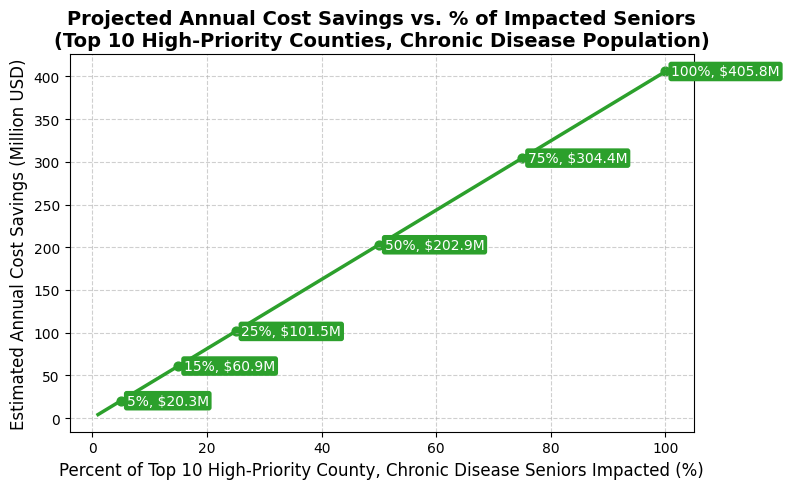

In [16]:
percentage_impacted = np.linspace(0.01, 1.00, 100) #going from 1% to 100%
#calculating savings as total with chronic disease from 65+ population in top 10 * avg disease cost * percent impacted
savings = total_with_chronic_disease * avg_disease_cost * percentage_impacted
plot.figure(figsize=(8,5))
plot.plot(percentage_impacted*100, savings/1e6, color="#2ca02c", linewidth=2.5)
#to mark for readability/interpretability
key_points = [5, 15, 25, 50, 75, 100]
for x in key_points:
    y = total_with_chronic_disease * avg_disease_cost * (x/100) / 1e6
    plot.scatter(x, y, color="#2ca02c", s=40)
    plot.text(
        x + 1, y,
        f"{x:.0f}%, ${y:.1f}M",
        fontsize=10, va='center', color='white',
        bbox=dict(facecolor="#2ca02c", edgecolor="none", boxstyle="round,pad=0.2")
    )
plot.title("Projected Annual Cost Savings vs. % of Impacted Seniors\n"
    "(Top 10 High-Priority Counties, Chronic Disease Population)", fontsize=14, weight='bold')
plot.xlabel("Percent of Top 10 High-Priority County, Chronic Disease Seniors Impacted (%)", fontsize=12)
plot.ylabel("Estimated Annual Cost Savings (Million USD)", fontsize=12)
plot.grid(True, linestyle='--', alpha=0.6)
plot.tight_layout()
plot.show()